# Time Series Classification

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from tslearn.utils import to_time_series_dataset, save_time_series_txt, load_time_series_txt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import pickle

In [2]:
data_path = '/home/mattiapggioli/lyrics2ts/data/classification/pp-rc/sbert/'
truncate=100
max_iter = 2000
paa_window_size = None
undersampling = None

In [3]:
# Parameters
data_path = (
    "/home/mattiapggioli/lyrics2ts/data/classification/rock-subgenres/sentiment/"
)
paa_window_size = 20
undersampling = 0.3


In [4]:
ts = load_time_series_txt(f'{data_path}/ts.txt')

In [5]:
ts.shape

(25000, 100, 1)

In [6]:
with open(f'{data_path}/y_class.npy', 'rb') as f:
    y = np.load(f, allow_pickle=True)

In [7]:
with open(f'{data_path}/X.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)

In [8]:
X.shape

(25000, 6)

In [9]:
set(y)

{'hard-rock', 'heavy-metal', 'indie', 'pop-rock', 'punk-rock'}

In [10]:
ts_train, ts_test, y_train, y_test = train_test_split(
    ts, y, test_size=0.20, random_state=42, stratify=y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

In [12]:
random.choice(ts_train)

array([[ 0.    ],
       [ 0.    ],
       [-0.1027],
       [-0.1027],
       [ 0.4215],
       [ 0.    ],
       [ 0.5719],
       [ 0.    ],
       [ 0.    ],
       [ 0.4939],
       [ 0.4939],
       [ 0.    ],
       [-0.4404],
       [ 0.25  ],
       [ 0.    ],
       [ 0.6486],
       [-0.296 ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [-0.4019],
       [ 0.    ],
       [ 0.3182],
       [-0.5106],
       [ 0.    ],
       [-0.7351],
       [ 0.3612],
       [ 0.    ],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [    nan],
       [  

<AxesSubplot:ylabel='Count'>

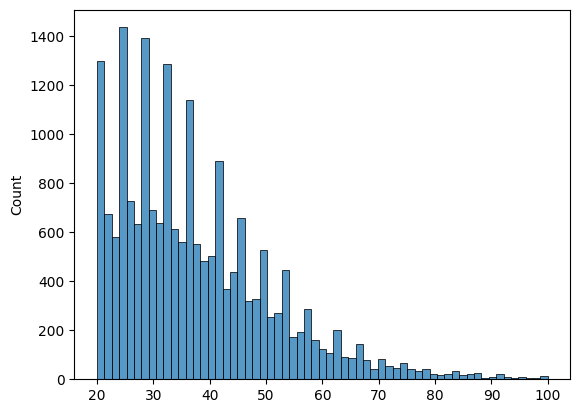

In [13]:
sns.histplot([t[~np.any(np.isnan(t), axis=1)].shape[0] for t in ts_train])

In [14]:
ts_train = ts_train[:, :truncate, :]
ts_test = ts_test[:, :truncate, :]

In [15]:
mean_arr = np.nanmean(ts_train, axis=1, keepdims=True)
nan_indices = np.isnan(ts_train)
ts_train[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

mean_arr = np.nanmean(ts_test, axis=1, keepdims=True)
nan_indices = np.isnan(ts_test)
ts_test[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

In [16]:
np.count_nonzero(np.isnan(X_train))

46

In [17]:
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

In [18]:
save_time_series_txt(f'{data_path}/ts_train.txt', ts_train)
save_time_series_txt(f'{data_path}/ts_test.txt', ts_test)

In [19]:
with open(f'{data_path}/X_train.npy', 'wb') as f:
    np.save(f, X_train, allow_pickle=True)

with open(f'{data_path}/X_test.npy', 'wb') as f:
    np.save(f, X_test, allow_pickle=True)

In [20]:
with open(f'{data_path}/y_train.npy', 'wb') as f:
    np.save(f, y_train, allow_pickle=True)

with open(f'{data_path}/y_test.npy', 'wb') as f:
    np.save(f, y_test, allow_pickle=True)

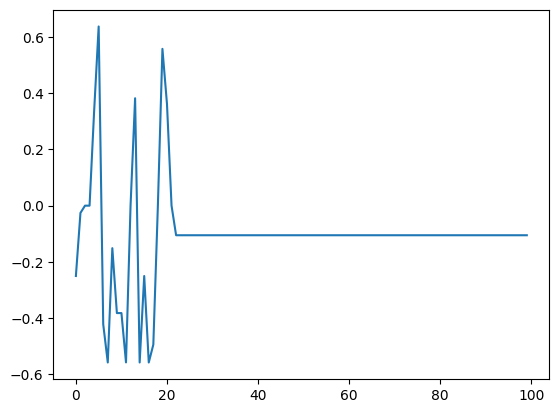

In [21]:
plt.plot(random.choice(ts_train))

In [22]:
# Parameters that require knowing if it's binary or multiclass (LightGBM, metrics)
if len(set(y)) == 2:
    avg_par = 'macro'
    obj_par = 'binary'
elif len(set(y)) > 2:
    avg_par = 'weighted'
    obj_par = 'multiclass'

## Classification

In [23]:
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier

In [24]:
metrics_data = {}

### Baseline: global features (No Time Series)

In [25]:
metrics_data['Global'] = {}

**Decision Tree**

In [26]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   hard-rock       0.21      0.20      0.21      1000
 heavy-metal       0.27      0.27      0.27      1000
       indie       0.22      0.21      0.22      1000
    pop-rock       0.25      0.24      0.24      1000
   punk-rock       0.21      0.22      0.21      1000

    accuracy                           0.23      5000
   macro avg       0.23      0.23      0.23      5000
weighted avg       0.23      0.23      0.23      5000



In [28]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [29]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   hard-rock       0.21      0.19      0.20      1000
 heavy-metal       0.33      0.39      0.36      1000
       indie       0.23      0.23      0.23      1000
    pop-rock       0.28      0.30      0.29      1000
   punk-rock       0.23      0.20      0.21      1000

    accuracy                           0.26      5000
   macro avg       0.26      0.26      0.26      5000
weighted avg       0.26      0.26      0.26      5000



In [31]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [32]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='multiclass')

In [33]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   hard-rock       0.20      0.12      0.15      1000
 heavy-metal       0.35      0.45      0.39      1000
       indie       0.24      0.25      0.24      1000
    pop-rock       0.29      0.36      0.32      1000
   punk-rock       0.23      0.19      0.21      1000

    accuracy                           0.27      5000
   macro avg       0.26      0.27      0.26      5000
weighted avg       0.26      0.27      0.26      5000



In [34]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

### Time Series Classification

#### Learning Shapelets

In [35]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict

2023-03-21 14:17:30.050433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-03-21 14:17:30.212533: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 14:17:30.212558: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-03-21 14:17:30.831747: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-21 14:17:30.831819: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-21 14:17:30.831828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [36]:
n_ts, ts_sz, _ = ts_train.shape
n_classes = len(set(y_train))

In [37]:
# Set the number of shapelets per size as done in the original paper
g_shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                         ts_sz=ts_sz,
                                                         n_classes=n_classes,
                                                         l=0.1,
                                                         r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', g_shapelet_sizes)

n_ts 20000
ts_sz 100
n_classes 5
shapelet_sizes {10: 6}


In [38]:
shapelet_sizes = {}
for key in g_shapelet_sizes:
    shapelet_sizes[key] = g_shapelet_sizes[key]
    shapelet_sizes[key*2] = g_shapelet_sizes[key]
    shapelet_sizes[key//2] = g_shapelet_sizes[key]
shapelet_sizes

{10: 6, 20: 6, 5: 6}

In [39]:
model = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                          optimizer="adam", 
                          weight_regularizer=.01, 
                          max_iter=max_iter, verbose=0, random_state=42)

/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [40]:
%%time
model.fit(ts_train, y_train)

2023-03-21 14:17:32.457203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-21 14:17:32.457239: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-21 14:17:32.457261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mattiapggioli-ThinkPad-E595): /proc/driver/nvidia/version does not exist
2023-03-21 14:17:32.457485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 2h 41min 52s, sys: 9min 12s, total: 2h 51min 4s
Wall time: 28min 22s


LearningShapelets(max_iter=2000, n_shapelets_per_size={5: 6, 10: 6, 20: 6},
                  optimizer='adam', random_state=42, weight_regularizer=0.01)

In [41]:
model.to_pickle(f'{data_path}/shapelets.pkl')

#### Shapelet-Based Classification

In [42]:
metrics_data['Shapelets'] = {}

In [43]:
X_train = model.transform(ts_train)
X_test = model.transform(ts_test)

In [44]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,8.249335,3.611318,2.796391,0.066644,0.001358,0.045446,2.429895,3.323981,3.788157,3.372087,1.057340,5.079569,4.004180,1.941783,1.846655,4.121922,3.374670,4.113391
1,7.618811,3.073110,2.247232,0.165849,0.019450,0.146845,2.196533,3.377940,3.812111,3.091929,1.341586,4.123682,3.684493,2.259670,2.096949,3.668335,3.002191,3.797429
2,8.287250,3.195580,2.243573,0.026373,0.000802,0.099436,2.031588,3.478823,3.966679,3.650556,1.081620,4.960857,3.684015,2.109211,2.024766,3.770867,3.082851,3.791200
3,7.376691,3.054037,2.387881,0.028461,0.000103,0.025451,2.465986,3.301531,3.635683,3.457446,0.907246,4.746076,3.775030,1.713073,1.638579,3.942616,3.143247,3.883000
4,7.381344,3.146829,2.801500,0.016386,0.002382,0.028698,2.553995,3.224820,3.407670,3.489281,0.899827,4.943593,4.121923,1.737306,1.655873,4.338996,3.532000,4.226434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6.956993,3.904643,2.814018,0.005363,0.009312,0.026869,2.775910,3.001448,3.344341,3.235052,0.743069,4.743472,4.546862,1.561148,1.543494,4.626707,3.870435,4.673015
4996,7.449565,3.808816,3.352306,0.029396,0.006749,0.058973,2.755566,3.091988,3.773387,3.489701,0.796193,5.076663,4.586673,1.708944,1.698335,4.699882,3.901682,4.716866
4997,8.242885,3.246572,2.542107,0.076165,0.000802,0.097618,2.303450,3.366522,3.788593,3.348715,1.130186,4.845490,3.716835,1.990725,1.873339,3.754174,2.978634,3.832455
4998,8.304624,2.833689,1.979945,0.100526,0.001358,0.029824,1.685824,3.571625,4.055044,3.635544,1.336111,5.238989,3.110342,2.399458,2.298709,3.118658,2.515052,3.210330


**Decision Tree**

In [45]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [46]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   hard-rock       0.22      0.23      0.23      1000
 heavy-metal       0.26      0.26      0.26      1000
       indie       0.20      0.19      0.19      1000
    pop-rock       0.23      0.22      0.23      1000
   punk-rock       0.22      0.22      0.22      1000

    accuracy                           0.23      5000
   macro avg       0.22      0.23      0.22      5000
weighted avg       0.22      0.23      0.22      5000



In [47]:
pickle.dump(clf, open(f'{data_path}/decision_tree.pkl', 'wb'))

In [48]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [49]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   hard-rock       0.23      0.20      0.22      1000
 heavy-metal       0.32      0.39      0.35      1000
       indie       0.24      0.23      0.23      1000
    pop-rock       0.29      0.34      0.31      1000
   punk-rock       0.26      0.20      0.22      1000

    accuracy                           0.27      5000
   macro avg       0.27      0.27      0.27      5000
weighted avg       0.27      0.27      0.27      5000



In [51]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [52]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='multiclass')

In [53]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   hard-rock       0.23      0.17      0.19      1000
 heavy-metal       0.33      0.41      0.37      1000
       indie       0.26      0.25      0.25      1000
    pop-rock       0.29      0.39      0.33      1000
   punk-rock       0.23      0.17      0.20      1000

    accuracy                           0.28      5000
   macro avg       0.27      0.28      0.27      5000
weighted avg       0.27      0.28      0.27      5000



In [54]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

#### KNN

In [55]:
X_train = ts_train.reshape((ts_train.shape[0], ts_train.shape[1]))
X_test = ts_test.reshape((ts_test.shape[0], ts_test.shape[1]))

In [56]:
X_train.shape

(20000, 100)

In [57]:
metrics_data['KNN'] = {}

**Euclidean Distance**

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [60]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   hard-rock       0.19      0.26      0.22      1000
 heavy-metal       0.26      0.23      0.24      1000
       indie       0.20      0.29      0.24      1000
    pop-rock       0.24      0.16      0.19      1000
   punk-rock       0.21      0.15      0.18      1000

    accuracy                           0.22      5000
   macro avg       0.22      0.22      0.21      5000
weighted avg       0.22      0.22      0.21      5000



In [61]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['Euclidean'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Dynamic Time Warping**

In [62]:
from pyts.classification import KNeighborsClassifier
from pyts.approximation import PiecewiseAggregateApproximation
from imblearn.under_sampling import ClusterCentroids
from sklearn_extra.cluster import KMedoids

In [63]:
if paa_window_size:
    paa = PiecewiseAggregateApproximation(window_size=paa_window_size)
    X_train = paa.transform(X_train)
    X_test = paa.transform(X_test)
    X_train.shape

In [64]:
if undersampling:
    total_samples = len(y_train)
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    samp_strat = dict(zip(unique_classes, np.floor(class_counts * undersampling).astype(int)))
    print(samp_strat)
    cc = ClusterCentroids(estimator=KMedoids(
        random_state=42), sampling_strategy=samp_strat, random_state=42)
    X_train, y_train = cc.fit_resample(X_train, y_train)
    X_train.shape

{'hard-rock': 1200, 'heavy-metal': 1200, 'indie': 1200, 'pop-rock': 1200, 'punk-rock': 1200}


/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 173 is empty! self.labels_[self.medoid_indices_[173]] may not be labeled with its corresponding cluster (173).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 626 is empty! self.labels_[self.medoid_indices_[626]] may not be labeled with its corresponding cluster (626).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1019 is empty! self.labels_[self.medoid_indices_[1019]] may not be labeled with its corresponding cluster (1019).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1064 is empty! self.labels_[self.medoid_indices_[1064]] may not be labeled with its corresponding cluster (10

/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 354 is empty! self.labels_[self.medoid_indices_[354]] may not be labeled with its corresponding cluster (354).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 398 is empty! self.labels_[self.medoid_indices_[398]] may not be labeled with its corresponding cluster (398).
  warnings.warn(


/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 104 is empty! self.labels_[self.medoid_indices_[104]] may not be labeled with its corresponding cluster (104).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 111 is empty! self.labels_[self.medoid_indices_[111]] may not be labeled with its corresponding cluster (111).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 304 is empty! self.labels_[self.medoid_indices_[304]] may not be labeled with its corresponding cluster (304).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 338 is empty! self.labels_[self.medoid_indices_[338]] may not be labeled with its corresponding cluster (338).
 

/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 452 is empty! self.labels_[self.medoid_indices_[452]] may not be labeled with its corresponding cluster (452).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1086 is empty! self.labels_[self.medoid_indices_[1086]] may not be labeled with its corresponding cluster (1086).
  warnings.warn(


/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 297 is empty! self.labels_[self.medoid_indices_[297]] may not be labeled with its corresponding cluster (297).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 328 is empty! self.labels_[self.medoid_indices_[328]] may not be labeled with its corresponding cluster (328).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 367 is empty! self.labels_[self.medoid_indices_[367]] may not be labeled with its corresponding cluster (367).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 383 is empty! self.labels_[self.medoid_indices_[383]] may not be labeled with its corresponding cluster (383).
 

In [65]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba',  metric_params={'window_size':3})

clf.fit(X_train, y_train)

KNeighborsClassifier(metric='dtw_sakoechiba', metric_params={'window_size': 3})

In [66]:
%%time
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   hard-rock       0.20      0.18      0.19      1000
 heavy-metal       0.27      0.41      0.32      1000
       indie       0.21      0.15      0.17      1000
    pop-rock       0.24      0.25      0.24      1000
   punk-rock       0.20      0.18      0.19      1000

    accuracy                           0.23      5000
   macro avg       0.22      0.23      0.22      5000
weighted avg       0.22      0.23      0.22      5000

CPU times: user 1h 27min 29s, sys: 643 ms, total: 1h 27min 30s
Wall time: 1h 27min 30s


In [67]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['DTW'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

## Overall Results

In [68]:
metrics_data = pd.DataFrame.from_dict({(i,j): metrics_data[i][j] 
                                       for i in metrics_data.keys() 
                                       for j in metrics_data[i].keys()},
                                       orient='index')

In [69]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

In [70]:
metrics_data

Accuracy  Precision  Recall        F1
Global    DecisionTree    0.2300   0.230042  0.2300  0.229887
          RandomForest    0.2620   0.256975  0.2620  0.258364
          LightGBM        0.2730   0.260896  0.2730  0.262111
Shapelets DecisionTree    0.2250   0.224983  0.2250  0.224913
          RandomForest    0.2722   0.267261  0.2722  0.267489
          LightGBM        0.2772   0.268931  0.2772  0.269046
KNN       Euclidean       0.2164   0.221228  0.2164  0.213493
          DTW             0.2308   0.224268  0.2308  0.223288

In [71]:
metrics_data.to_csv(f'{data_path}/metrics.csv')